In [24]:
from tools.utils import *
from tools.het_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
num_layers = 2
intra_aggr='mean'
inter_aggr='sum'
dropout = 0.5

# Training
batch_size = 8
epochs = 15
lr = 1e-4
maxlr = 1e-3

# Preprocessing

In [26]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [27]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [28]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [29]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [30]:
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# GraphConv

In [ ]:
experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_GraphConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (B): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): HeteroConv(num_relations=6)
      (post_lin): ModuleDict(
        (A): MLP(
          (layers): ModuleList(
            (0): Linear(-1, 128, bias=True)
            (1): Dropout(p=0.5, inplace=False)
            (2): Linear(128, 128, bias=True)
          )
        )
        (B): MLP(
          (layers): ModuleList(
            (0):

In [32]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [33]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/15
Train Loss: 4.7944 | Validation Loss: 4.6481
Train Acc: 0.1286 | Validation Acc: 0.1778
Train F1: 0.0278 | Validation F1: 0.0805

Epoch 2/15
Train Loss: 2.5356 | Validation Loss: 1.9187
Train Acc: 0.1976 | Validation Acc: 0.1667
Train F1: 0.1822 | Validation F1: 0.0476

Epoch 3/15
Train Loss: 1.8900 | Validation Loss: 1.8219
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.1615 | Validation F1: 0.0672

Epoch 4/15
Train Loss: 1.8401 | Validation Loss: 1.8539
Train Acc: 0.2024 | Validation Acc: 0.1889
Train F1: 0.1869 | Validation F1: 0.0995

Epoch 5/15
Train Loss: 1.8159 | Validation Loss: 1.7588
Train Acc: 0.2190 | Validation Acc: 0.2444
Train F1: 0.2110 | Validation F1: 0.1200

Epoch 6/15
Train Loss: 1.7749 | Validation Loss: 1.7967
Train Acc: 0.2167 | Validation Acc: 0.1778
Train F1: 0.1977 | Validation F1: 0.0660

Epoch 7/15
Train Loss: 1.7638 | Validation Loss: 1.7881
Train Acc: 0.2429 | Validation Acc: 0.2778
Train F1: 0.2209 | Validation F1: 0.1917

Epoch 8/15
Tr

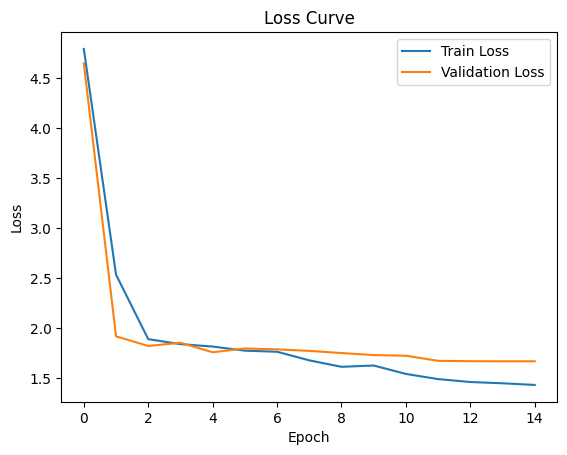

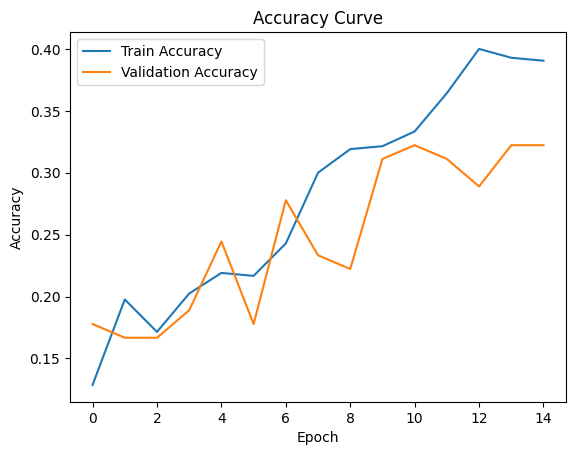

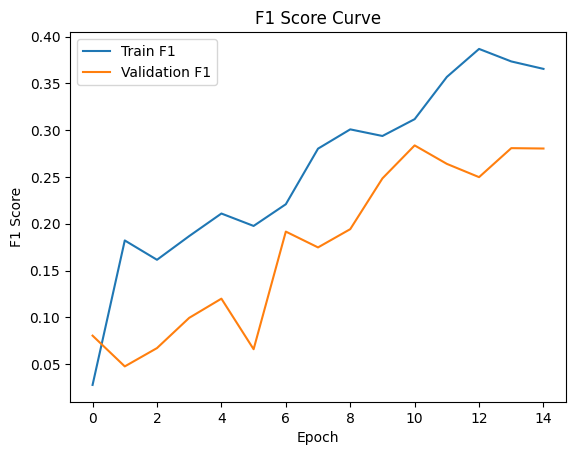

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,4.7944,4.6481,0.1286,0.1778,0.0278,0.0805
1,2,2.5356,1.9187,0.1976,0.1667,0.1822,0.0476
2,3,1.8900,1.8219,0.1714,0.1667,0.1615,0.0672
3,4,1.8401,1.8539,0.2024,0.1889,0.1869,0.0995
4,5,1.8159,1.7588,0.2190,0.2444,0.2110,0.1200
5,6,1.7749,1.7967,0.2167,0.1778,0.1977,0.0660
6,7,1.7638,1.7881,0.2429,0.2778,0.2209,0.1917
7,8,1.6780,1.7725,0.3000,0.2333,0.2803,0.1748
8,9,1.6132,1.7511,0.3190,0.2222,0.3009,0.1943
9,10,1.6263,1.7305,0.3214,0.3111,0.2938,0.2485


In [34]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# SAGEConv

In [ ]:
experiment_name = f"ENZYMES-HeteroGNN_SAGEConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_SAGEConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_SAGEConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (B): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): HeteroConv(num_relations=6)
      (post_lin): ModuleDict(
        (A): MLP(
          (layers): ModuleList(
            (0): Linear(-1, 128, bias=True)
            (1): Dropout(p=0.5, inplace=False)
            (2): Linear(128, 128, bias=True)
          )
        )
        (B): MLP(
          (layers): ModuleList(
            (0): 

In [36]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [37]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/15
Train Loss: 4.7944 | Validation Loss: 4.6481
Train Acc: 0.1286 | Validation Acc: 0.1778
Train F1: 0.0278 | Validation F1: 0.0805

Epoch 2/15
Train Loss: 2.5356 | Validation Loss: 1.9187
Train Acc: 0.1976 | Validation Acc: 0.1667
Train F1: 0.1822 | Validation F1: 0.0476

Epoch 3/15
Train Loss: 1.8900 | Validation Loss: 1.8219
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.1615 | Validation F1: 0.0672

Epoch 4/15
Train Loss: 1.8401 | Validation Loss: 1.8539
Train Acc: 0.2024 | Validation Acc: 0.1889
Train F1: 0.1869 | Validation F1: 0.0995

Epoch 5/15
Train Loss: 1.8159 | Validation Loss: 1.7588
Train Acc: 0.2190 | Validation Acc: 0.2444
Train F1: 0.2110 | Validation F1: 0.1200

Epoch 6/15
Train Loss: 1.7749 | Validation Loss: 1.7967
Train Acc: 0.2167 | Validation Acc: 0.1778
Train F1: 0.1977 | Validation F1: 0.0660

Epoch 7/15
Train Loss: 1.7638 | Validation Loss: 1.7881
Train Acc: 0.2429 | Validation Acc: 0.2778
Train F1: 0.2209 | Validation F1: 0.1917

Epoch 8/15
Tr

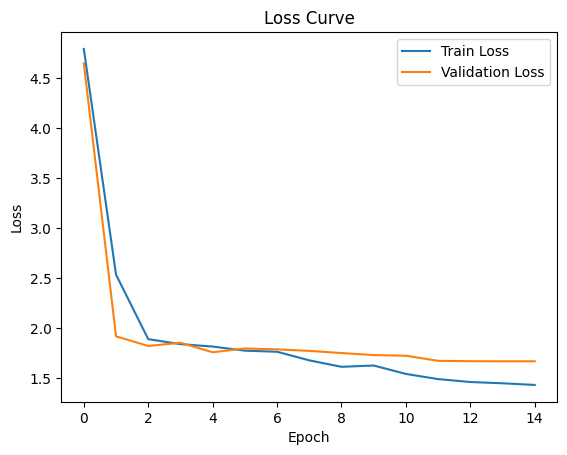

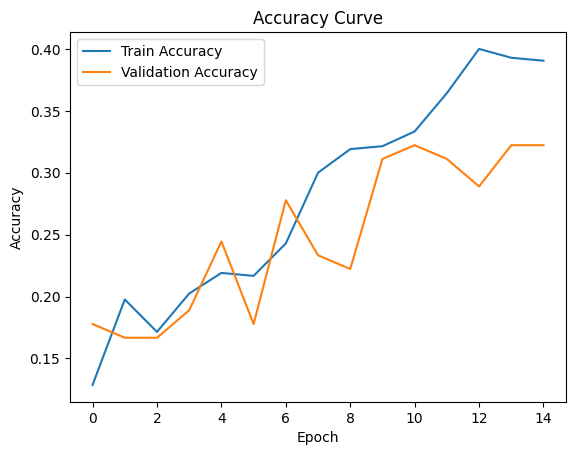

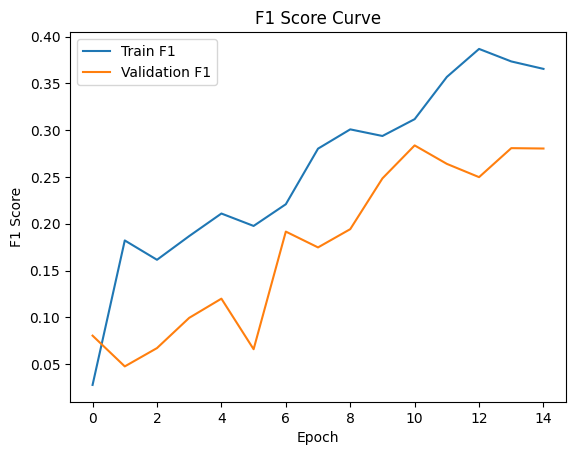

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,4.7944,4.6481,0.1286,0.1778,0.0278,0.0805
1,2,2.5356,1.9187,0.1976,0.1667,0.1822,0.0476
2,3,1.8900,1.8219,0.1714,0.1667,0.1615,0.0672
3,4,1.8401,1.8539,0.2024,0.1889,0.1869,0.0995
4,5,1.8159,1.7588,0.2190,0.2444,0.2110,0.1200
5,6,1.7749,1.7967,0.2167,0.1778,0.1977,0.0660
6,7,1.7638,1.7881,0.2429,0.2778,0.2209,0.1917
7,8,1.6780,1.7725,0.3000,0.2333,0.2803,0.1748
8,9,1.6132,1.7511,0.3190,0.2222,0.3009,0.1943
9,10,1.6263,1.7305,0.3214,0.3111,0.2938,0.2485


In [38]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# GATConv

In [ ]:
experiment_name = f"ENZYMES-HeteroGNN_GATConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GATConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_GATConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (B): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): HeteroConv(num_relations=6)
      (post_lin): ModuleDict(
        (A): MLP(
          (layers): ModuleList(
            (0): Linear(-1, 128, bias=True)
            (1): Dropout(p=0.5, inplace=False)
            (2): Linear(128, 128, bias=True)
          )
        )
        (B): MLP(
          (layers): ModuleList(
            (0): L

In [40]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [41]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/15
Train Loss: 4.8181 | Validation Loss: 4.7670
Train Acc: 0.0881 | Validation Acc: 0.1556
Train F1: 0.0161 | Validation F1: 0.0462

Epoch 2/15
Train Loss: 3.4316 | Validation Loss: 1.9841
Train Acc: 0.1500 | Validation Acc: 0.1778
Train F1: 0.1172 | Validation F1: 0.0682

Epoch 3/15
Train Loss: 1.9370 | Validation Loss: 1.8656
Train Acc: 0.1714 | Validation Acc: 0.1889
Train F1: 0.1607 | Validation F1: 0.0955

Epoch 4/15
Train Loss: 1.8691 | Validation Loss: 1.8737
Train Acc: 0.1667 | Validation Acc: 0.2333
Train F1: 0.1409 | Validation F1: 0.1611

Epoch 5/15
Train Loss: 1.8666 | Validation Loss: 1.8324
Train Acc: 0.1548 | Validation Acc: 0.1778
Train F1: 0.1403 | Validation F1: 0.0664

Epoch 6/15
Train Loss: 1.8209 | Validation Loss: 1.8172
Train Acc: 0.1929 | Validation Acc: 0.1889
Train F1: 0.1965 | Validation F1: 0.1269

Epoch 7/15
Train Loss: 1.7922 | Validation Loss: 1.7881
Train Acc: 0.1929 | Validation Acc: 0.1667
Train F1: 0.1794 | Validation F1: 0.0863

Epoch 8/15
Tr

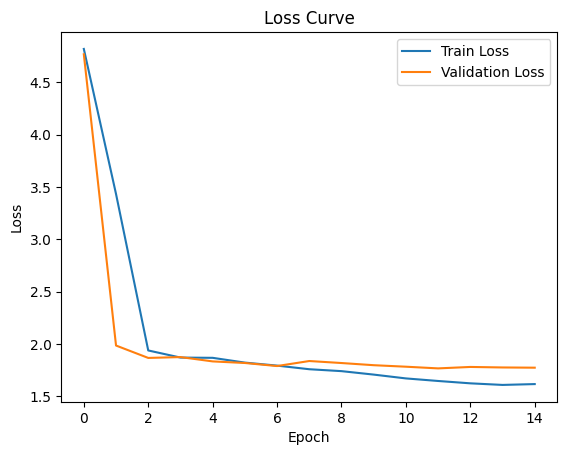

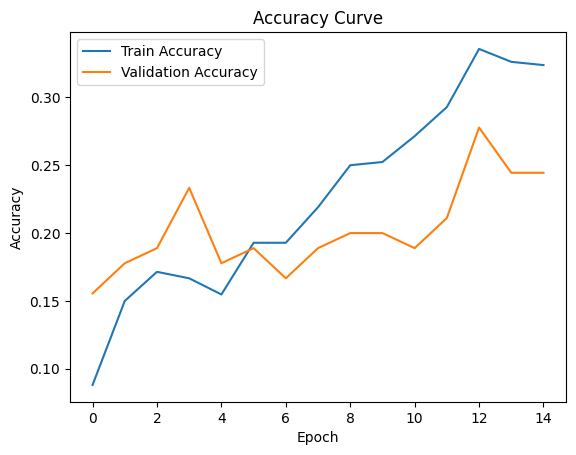

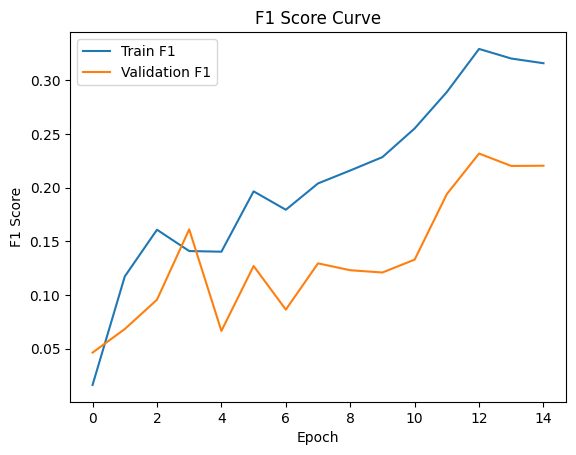

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,4.8181,4.7670,0.0881,0.1556,0.0161,0.0462
1,2,3.4316,1.9841,0.1500,0.1778,0.1172,0.0682
2,3,1.9370,1.8656,0.1714,0.1889,0.1607,0.0955
3,4,1.8691,1.8737,0.1667,0.2333,0.1409,0.1611
4,5,1.8666,1.8324,0.1548,0.1778,0.1403,0.0664
5,6,1.8209,1.8172,0.1929,0.1889,0.1965,0.1269
6,7,1.7922,1.7881,0.1929,0.1667,0.1794,0.0863
7,8,1.7577,1.8361,0.2190,0.1889,0.2039,0.1294
8,9,1.7394,1.8169,0.2500,0.2000,0.2160,0.1230
9,10,1.7064,1.7962,0.2524,0.2000,0.2285,0.1209


In [42]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)